In [61]:
#Cleaning up  https://github.com/dasotelo/Python_Projects/blob/master/Wine_Bag_Boost.py
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

In [70]:
wine_df=pd.read_csv('winemag-data_first150k.csv')
wine_df=wine_df.loc[wine_df.country=='US',['points','price','region_1', 'variety','winery']]
wine_df=wine_df.dropna(axis=0,how='any')

In [71]:
qualityCutoff = 90
pointRange = wine_df.points.unique().tolist()
qualityMap = {}
for point in pointRange:
    if point >= qualityCutoff:
        qualityMap[point] = str(qualityCutoff) + "+"
    else:
        qualityMap[point] = "<" + str(qualityCutoff)
wine_df['Quality']=wine_df.points.map(qualityMap)
wine_df=wine_df.drop('points',axis=1)

In [72]:
wine_df.head()

,price,region_1,variety,winery,Quality
0,235.0,Napa Valley,Cabernet Sauvignon,Heitz,90+
2,90.0,Knights Valley,Sauvignon Blanc,Macauley,90+
3,65.0,Willamette Valley,Pinot Noir,Ponzi,90+
8,65.0,Chehalem Mountains,Pinot Noir,Bergström,90+
9,60.0,Sonoma Coast,Pinot Noir,Blue Farm,90+


In [ ]:
# Prepare data by labeling/encoding
def labelCategoryData(df,label):
    labels = LabelEncoder().fit(np.unique(df[label].values))
    df[label+'_enc'] = labels.transform(df[label])
    return(df)

In [73]:
labels = ['region_1','variety','winery']
for label in labels:
    wine_df = labelCategoryData(wine_df,label)
wine_df=wine_df.drop(['region_1','variety','winery'],axis=1)

In [78]:
wine_df.head()

,price,Quality,region_1_enc,variety_enc,winery_enc
0,235.0,90+,132,24,1890
2,90.0,90+,81,158,2552
3,65.0,90+,256,133,3248
8,65.0,90+,33,133,419
9,60.0,90+,212,133,483


In [ ]:
wine_train,wine_test=train_test_split(wine_df,test_size=0.90)
x=wine_train.loc[:,['price','region_1_enc','variety_enc','winery_enc']]
y=wine_train['Quality']
clf=DecisionTreeClassifier(max_features=None)
clf=clf.fit(x,y)

In [83]:
# Report classification results.  training dataset first, then test.  
train_error=y==clf.predict(x)
test_error=wine_test['Quality']==clf.predict(wine_test.loc[:,['price','region_1_enc','variety_enc','winery_enc']])
print('@@@@@@@@@@@@@@@@@@@@@@@@@')
print('CART w/ #leaf nodes = ',clf.tree_.node_count) 
print('   ',clf.n_features_,' features out of: 4 features')                          
print('   training accuracy: ','{:.1%}'.format(sum(train_error)/len(
    train_error)))
print('   test accuracy: ','{:.1%}'.format(sum(test_error)/len(test_error)))

@@@@@@@@@@@@@@@@@@@@@@@@@
CART w/ #leaf nodes =  3315
    4  features out of: 4 features
   training accuracy:  98.4%
   test accuracy:  69.9%


In [87]:
# Control the number of n_estimators in ensemble functions
max_n_ests=25

# Create dataframe to record results of ensembles.
results=pd.DataFrame([],columns=list(['type','n_leaf','n_est', 'train_acc','test_acc']))

# Train bagging ensemble on iterations of n_estimators=i
# and iterations of stump max_leaf_nodes=j
for j in [500,2000,8000,99999]:
    clf_stump=DecisionTreeClassifier(max_features=None,max_leaf_nodes=j)
    for i in np.arange(1,max_n_ests):
        #print(i)
        baglfy=BaggingClassifier(base_estimator=clf_stump,n_estimators=i,
            max_samples=1.0)
        baglfy=baglfy.fit(x,y)
        bag_tr_err=y==baglfy.predict(x)
        bag_tst_err=wine_test['Quality']==baglfy.predict( \
            wine_test.loc[:,['price','region_1_enc','variety_enc','winery_enc']])
        run_rslt=pd.DataFrame([['bag',j,i,sum(bag_tr_err)/len(bag_tr_err),
            sum(bag_tst_err)/len(bag_tst_err)]],
            columns=list(['type','n_leaf','n_est','train_acc','test_acc']))
        results=results.append(run_rslt)

In [88]:
# Train boosting ensemble on iterations of n_estimators=i
# and iterations of stump max_leaf_nodes=j
for j in [500,2000,8000,99999]:
    clf_stump=DecisionTreeClassifier(max_features=None,max_leaf_nodes=j)
    for i in np.arange(1,max_n_ests):
        #print(i)
        bstlfy=AdaBoostClassifier(base_estimator=clf_stump,n_estimators=i)
        bstlfy=bstlfy.fit(x,y)
        bst_tr_err=y==bstlfy.predict(x)
        bst_tst_err=wine_test['Quality']==bstlfy.predict( \
            wine_test.loc[:,['price','region_1_enc','variety_enc','winery_enc']])
        run_rslt=pd.DataFrame([['bst',j,i,sum(bst_tr_err)/len(bst_tr_err),
            sum(bst_tst_err)/len(bst_tst_err)]],
            columns=list(['type','n_leaf','n_est','train_acc','test_acc']))
        results=results.append(run_rslt)

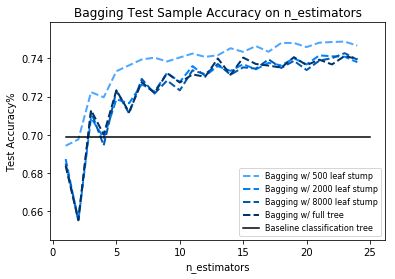

In [92]:
# Plot Bagging accuracy results on test data
# 500 leaf stumps
plt.plot(results.loc[((results.type=='bag')&(results.n_leaf==500)), \
    ['n_est']],results.loc[((results.type=='bag')&(results.n_leaf==500)), \
    ['test_acc']],linestyle='--',linewidth=2,color='#4da6ff', \
    label='Bagging w/ 500 leaf stump')
# 2000 leaf stumps
plt.plot(results.loc[((results.type=='bag')&(results.n_leaf==2000)), \
    ['n_est']],results.loc[((results.type=='bag')&(results.n_leaf==2000)), \
    ['test_acc']],linestyle='--',linewidth=2,color='#0080ff', \
    label='Bagging w/ 2000 leaf stump')
# 8000 leaf stumps
plt.plot(results.loc[((results.type=='bag')&(results.n_leaf==8000)), \
    ['n_est']],results.loc[((results.type=='bag')&(results.n_leaf==8000)), \
    ['test_acc']],linestyle='--',linewidth=2,color='#0059b3', \
    label='Bagging w/ 8000 leaf stump')
# Full Classification Trees (no early termination)
plt.plot(results.loc[((results.type=='bag')&(results.n_leaf==99999)), \
    ['n_est']],results.loc[((results.type=='bag')&(results.n_leaf==99999)), \
    ['test_acc']],linestyle='--',linewidth=2,color='#003366', \
    label='Bagging w/ full tree')
# Plot test accuracy of baseline classification tree
clf_test_acc=sum(test_error)/len(test_error)
plt.plot([1,max_n_ests],[clf_test_acc,clf_test_acc],color='k', \
    label='Baseline classification tree')
plt.legend(fontsize=8)
plt.title('Bagging Test Sample Accuracy on n_estimators')
plt.ylim([results.loc[results.type=='bag',['test_acc']].values.min()-0.01, \
    results.loc[results.type=='bag',['test_acc']].values.max()+0.01])
plt.ylabel('Test Accuracy%')
plt.xlabel('n_estimators')
plt.show()


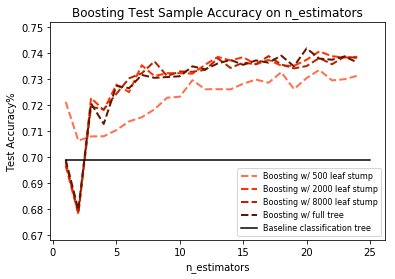

In [93]:
# Plot Boosting accuracy results on test data
# 500 leaf stumps
plt.plot(results.loc[((results.type=='bst')&(results.n_leaf==500)), \
    ['n_est']],results.loc[((results.type=='bst')&(results.n_leaf==500)), \
    ['test_acc']],linestyle='--',linewidth=2,color='#ff704d', \
    label='Boosting w/ 500 leaf stump')
# 2000 leaf stumps
plt.plot(results.loc[((results.type=='bst')&(results.n_leaf==2000)), \
    ['n_est']],results.loc[((results.type=='bst')&(results.n_leaf==2000)), \
    ['test_acc']],linestyle='--',linewidth=2,color='#ff3300', \
    label='Boosting w/ 2000 leaf stump')
# 8000 leaf stumps
plt.plot(results.loc[((results.type=='bst')&(results.n_leaf==8000)), \
    ['n_est']],results.loc[((results.type=='bst')&(results.n_leaf==8000)), \
    ['test_acc']],linestyle='--',linewidth=2,color='#b32400', \
    label='Boosting w/ 8000 leaf stump')
# Full Classification Trees (no early termination)
plt.plot(results.loc[((results.type=='bst')&(results.n_leaf==99999)), \
    ['n_est']],results.loc[((results.type=='bst')&(results.n_leaf==99999)), \
    ['test_acc']],linestyle='--',linewidth=2,color='#661400', \
    label='Boosting w/ full tree')
# Plot test accuracy of baseline classification tree
plt.plot([1,max_n_ests],[clf_test_acc,clf_test_acc],color='k', \
    label='Baseline classification tree')
plt.legend(fontsize=8)
plt.title('Boosting Test Sample Accuracy on n_estimators')
plt.ylim([results.loc[results.type=='bst',['test_acc']].values.min()-0.01, \
    results.loc[results.type=='bst',['test_acc']].values.max()+0.01])
plt.ylabel('Test Accuracy%')
plt.xlabel('n_estimators')
plt.show()

In [94]:
# ROC curve for baseline classification tree
clf_probs=clf.predict_proba(wine_test.loc[:,['price','region_1_enc','variety_enc','winery_enc']])
fpr1,tpr1,thr1=roc_curve(np.where(wine_test['Quality']=='90+',1.,0.), \
    clf_probs[:,0])
# ROC curve for bagging ensemble using full classification trees
bag_probs=baglfy.predict_proba(wine_test.loc[:,['price','region_1_enc','variety_enc','winery_enc']])
fpr2,tpr2,thr2=roc_curve(np.where(wine_test['Quality']=='90+',1.,0.), \
    bag_probs[:,0])
# ROC curve for boosting ensemble using full classification trees
bst_probs=bstlfy.predict_proba(wine_test.loc[:,['price','region_1_enc','variety_enc','winery_enc']])
fpr3,tpr3,thr3=roc_curve(np.where(wine_test['Quality']=='90+',1.,0.), \
    bst_probs[:,0])

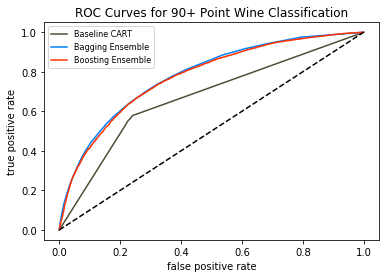

In [95]:
# Plot ROC Curves
plt.plot(fpr1,tpr1,color='#4d4d33',label='Baseline CART')
plt.plot(fpr2,tpr2,color='#0080ff',label='Bagging Ensemble')
plt.plot(fpr3,tpr3,color='#ff3300',label='Boosting Ensemble')
plt.plot([0.,1.],[0.,1.],color='k',linestyle='--')
plt.title('ROC Curves for 90+ Point Wine Classification')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(fontsize=8)
plt.show()